# Similarity Search Benchmarking

These benchmarks were originally run on an early 2015 MacBook Pro with a 2.7 GHz dual-core i5 processor and 8GB of memory. 

They make use of a ChEMBL_27 dataset. 

In [1]:
import mongordkit
import time
import pymongo
import rdkit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from os import sys
import pandas as pd
from rdkit import Chem
from statistics import mean
import mongomock
from rdkit.Chem import AllChem
from mongordkit.Database import write
from mongordkit.Search import similarity

In [4]:
#Create a mongomock database instance and write to it. 
client = mongomock.MongoClient()
db = client.db

#Write 200 molecules into the database
write.writeFromSDF(db.molecules, '../../data/test_data/first_200.props.sdf', 'test', chunk_size=100, limit=199)
doc = db.molecules.find_one()
m = Chem.Mol(doc['rdmol'])

populating mongodb collection with compounds from chembl...
199 molecules successfully imported


In [3]:
#Add Morgan fingerprints into the database
similarity.addMorganFingerprints(db)

In [14]:
#Check that similarity search is working, at least for one molecule. 
doc = db.molecules.find_one()
m = Chem.Mol(doc['rdmol'])
results = similarity.similaritySearch(m, db, .8)
results

[]

In [4]:
#Create a regular mongoDB database instance and write the first 1000 molecules to it. 
client = pymongo.MongoClient()
db = client.db
db.molecules.drop()
db.mfp_counts.drop()
write.writeFromSDF(db, '../../../chembl_27.sdf', 'test', reg_option='standard_setting', index_option='inchikey', chunk_size=500, limit=500)

populating mongodb collection with compounds from chembl...
inserted chunk...
inserted chunk...
1000 molecules successfully imported


1000

In [9]:
def calc_tanimoto(Na, Nb):
    Nab = len(set(Na).intersection((set(Nb))))
    return float(Nab) / (len(Na) + len(Nb) - Nab)

def similarity_search_naive(query_mol, db, threshold): 
    results = []
    qfp = list(AllChem.GetMorganFingerprintAsBitVect(query_mol, 2, nBits=1024).GetOnBits())
    for mol in db.molecules.find():
        mfp = list(AllChem.GetMorganFingerprintAsBitVect(Chem.Mol(mol['rdmol']), 2, nBits=1024).GetOnBits())
        tanimoto = calc_tanimoto(qfp, mfp)
        if calc_tanimoto(qfp, mfp) >= threshold:
            results.append([tanimoto, mol['smiles']])
    return results

In [6]:
#Run benchmarks for similarity search with and without aggregation parameters, then with LSH + aggregation. 
thresholds = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
times = []
repetitions = 5
for t in thresholds: 
    print("Measuring performance for similarity threshold {}.".format(t))
    temp_times = []
    for r in range(repetitions):
        start = time.time()
        for m in db.molecules.find():
            mol = Chem.Mol(m['rdmol'])
            _ = similarity.similaritySearch(mol, db, t)
        end = time.time()
        temp_times.append(end - start)
    times.append([t, mean(temp_times)])
print(times)


Measuring performance for similarity threshold 0.7.
Measuring performance for similarity threshold 0.75.
Measuring performance for similarity threshold 0.8.
Measuring performance for similarity threshold 0.85.
Measuring performance for similarity threshold 0.9.
Measuring performance for similarity threshold 0.95.
[[0.7, 3.236401987075806], [0.75, 2.964214563369751], [0.8, 2.850223159790039], [0.85, 2.716036558151245], [0.9, 2.50888934135437], [0.95, 2.7822859287261963]]
Measuring performance for similarity threshold 0.7.


NameError: name 'query_mol' is not defined

In [17]:
for t in thresholds: 
    print("Measuring performance for similarity threshold {}.".format(t))
    temp_times = []
    for r in range(5):
        start = time.time()
        counter = 0
        for m in db.molecules.find():
            if counter > 100: 
                break
            mol = Chem.Mol(m['rdmol'])
            _ = similarity_search_naive(mol, db, t)
            counter += 1
        end = time.time()
        temp_times.append(end - start)
    times.append([t, mean(temp_times)])
print(times)

Measuring performance for similarity threshold 0.7.
Measuring performance for similarity threshold 0.75.


KeyboardInterrupt: 

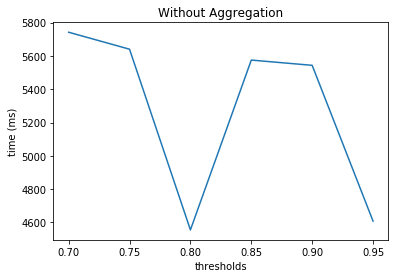

In [40]:
x_list = [v[0] for v in times]
y_list = [v[1]*1000 for v in times]
plt.xlabel('thresholds')
plt.ylabel('time (ms)')
plt.title('Without Aggregation')
plt.plot(x_list, y_list)

Measuring performance for similarity threshold 0.7.
Measuring performance for similarity threshold 0.75.
Measuring performance for similarity threshold 0.8.
Measuring performance for similarity threshold 0.85.
Measuring performance for similarity threshold 0.9.
Measuring performance for similarity threshold 0.95.
[[0.7, 6.002911186218261], [0.75, 5.983159065246582], [0.8, 5.641262626647949], [0.85, 5.888340759277344], [0.9, 6.869273900985718], [0.95, 5.446581506729126]]


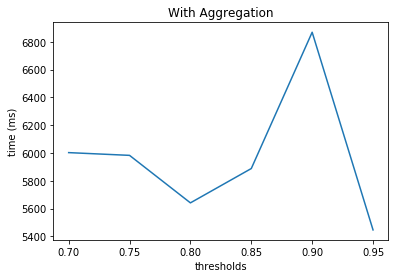

In [41]:
thresholds = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
times = []
repetitions = 5
for t in thresholds: 
    print("Measuring performance for similarity threshold {}.".format(t))
    temp_times = []
    for r in range(repetitions):
        start = time.time()
        for m in db.molecules.find():
            mol = Chem.Mol(m['rdmol'])
            _ = similarity.similaritySearchAggregate(mol, db, t)
        end = time.time()
        temp_times.append(end - start)
    times.append([t, mean(temp_times)])
print(times)
x_list = [v[0] for v in times]
y_list = [v[1]*1000 for v in times]
plt.xlabel('thresholds')
plt.ylabel('time (ms)')
plt.title('With Aggregation')
plt.plot(x_list, y_list)

In [42]:
db.molecules.drop()
db.mfp_counts.drop()
write.writeFromSDF(db, '../../../chembl_27.sdf', 'test', reg_option='inchikey', index_option='inchikey', chunk_size=500, limit=500)
similarity.addMorganFingerprints(db)

populating mongodb collection with compounds from chembl...
The specified setting does not exist. Will only insert default molecules
inserted chunk...
inserted chunk...
1000 molecules successfully imported


Measuring performance for similarity threshold 0.7.
Measuring performance for similarity threshold 0.75.
Measuring performance for similarity threshold 0.8.
Measuring performance for similarity threshold 0.85.
Measuring performance for similarity threshold 0.9.
Measuring performance for similarity threshold 0.95.
[[0.7, 0.0038346290588378907], [0.75, 0.003863954544067383], [0.8, 0.00497593879699707], [0.85, 0.00534672737121582], [0.9, 0.004187107086181641], [0.95, 0.006510639190673828]]


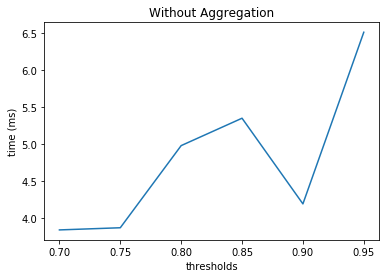

In [47]:
#Compute benchmarks with a fingerprint counts collection.
thresholds = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
times = []
repetitions = 5
for t in thresholds: 
    print("Measuring performance for similarity threshold {}.".format(t))
    temp_times = []
    for r in range(repetitions):
        start = time.time()
        for m in db.molecules.find():
            mol = Chem.Mol(m['rdmol'])
            _ = similarity.similaritySearch(mol, db, t)
        end = time.time()
        temp_times.append(end - start)
    times.append([t, mean(temp_times)])
print(times)
x_list = [v[0] for v in times]
y_list = [v[1]*1000 for v in times]
plt.xlabel('thresholds')
plt.ylabel('time (ms)')
plt.title('Without Aggregation')
plt.plot(x_list, y_list)

Measuring performance for similarity threshold 0.7.
Measuring performance for similarity threshold 0.75.
Measuring performance for similarity threshold 0.8.
Measuring performance for similarity threshold 0.85.
Measuring performance for similarity threshold 0.9.
Measuring performance for similarity threshold 0.95.
[[0.7, 0.009987068176269532], [0.75, 0.0059474468231201175], [0.8, 0.005334234237670899], [0.85, 0.0038384437561035157], [0.9, 0.0040286540985107425], [0.95, 0.0037296295166015627]]


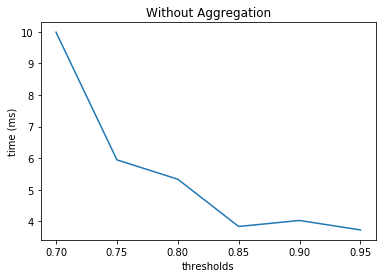

In [45]:
times = []
for t in thresholds: 
    print("Measuring performance for similarity threshold {}.".format(t))
    temp_times = []
    for r in range(repetitions):
        start = time.time()
        for m in db.molecules.find():
            mol = Chem.Mol(m['rdmol'])
            _ = similarity.similaritySearchAggregate(mol, db, t)
        end = time.time()
        temp_times.append(end - start)
    times.append([t, mean(temp_times)])
print(times)
x_list = [v[0] for v in times]
y_list = [v[1]*1000 for v in times]
plt.xlabel('thresholds')
plt.ylabel('time (ms)')
plt.title('Without Aggregation')
plt.plot(x_list, y_list)